In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import math
import pprint
from sklearn import preprocessing
import re

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer, sent_tokenize
import nltk
nltk.download('punkt')
from nltk import word_tokenize

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mattcirelli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Update SIA with Loughran McDonald Dictionary

import csv
import pandas as pd

# stock market lexicon
stock_lex = pd.read_csv('stock_lex.csv')

stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

#update the positive and negative dictionaries
positive = []
reader = csv.reader('lm_positive.csv')
for row in reader:
    positive.append(row[0].strip())
    
negative = []
reader = csv.reader('lm_negative.csv')
for row in reader:
    entry = row[0].strip().split(" ")
    if len(entry) > 1:
        negative.extend(entry)
    else:
        negative.append(entry[0])

final_lex = {}
final_lex.update({word:2.0 for word in positive})
final_lex.update({word:-2.0 for word in negative})
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

In [5]:
data = pd.read_csv('pfizer_news.csv')

In [6]:
data.head()

,Unnamed: 0,company,id,publication_date,summary,title,url
0,0,NaN,nws_xY9rOa,2019-08-07 15:00:03+00:00,Conatus' (CNAT) earnings and revenues surpass ...,"Conatus (CNAT) Beats on Q2 Earnings, Stops Emr...",https://finance.yahoo.com/news/conatus-cnat-be...
1,1,NaN,nws_kp3kmk,2019-08-06 21:10:45+00:00,What happened Shares of Teva Pharmaceutical In...,Here's What's Pushing Teva Pharmaceutical Indu...,http://articlefeeds.nasdaq.com/~r/nasdaq/symbo...
2,2,NaN,nws_WOkE6J,2019-08-06 21:10:45+00:00,What happened Shares of Teva Pharmaceutical In...,Here's What's Pushing Teva Pharmaceutical Indu...,http://articlefeeds.nasdaq.com/~r/nasdaq/symbo...
3,3,NaN,nws_lwdKnb,2019-08-06 13:46:44+00:00,Top Health Care Stocks Top Health Care Stocks ...,"Health Care Sector Update for 08/06/2019: BDX,...",http://articlefeeds.nasdaq.com/~r/nasdaq/symbo...
4,4,NaN,nws_YnV8LG,2019-08-06 13:46:44+00:00,Top Health Care Stocks Top Health Care Stocks ...,"Health Care Sector Update for 08/06/2019: BDX,...",http://articlefeeds.nasdaq.com/~r/nasdaq/symbo...


In [7]:
data['publication_date']=pd.to_datetime(data.publication_date,format='%Y-%m-%d')
data.index =data['publication_date']


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9885 entries, 2019-08-07 15:00:03 to 2015-11-23 22:32:12
Data columns (total 7 columns):
Unnamed: 0          9885 non-null int64
company             0 non-null float64
id                  9885 non-null object
publication_date    9885 non-null datetime64[ns]
summary             9885 non-null object
title               9885 non-null object
url                 9885 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 617.8+ KB


In [9]:
data.head()

,Unnamed: 0,company,id,publication_date,summary,title,url
publication_date,,,,,,,
2019-08-07 15:00:03,0,NaN,nws_xY9rOa,2019-08-07 15:00:03,Conatus' (CNAT) earnings and revenues surpass ...,"Conatus (CNAT) Beats on Q2 Earnings, Stops Emr...",https://finance.yahoo.com/news/conatus-cnat-be...
2019-08-06 21:10:45,1,NaN,nws_kp3kmk,2019-08-06 21:10:45,What happened Shares of Teva Pharmaceutical In...,Here's What's Pushing Teva Pharmaceutical Indu...,http://articlefeeds.nasdaq.com/~r/nasdaq/symbo...
2019-08-06 21:10:45,2,NaN,nws_WOkE6J,2019-08-06 21:10:45,What happened Shares of Teva Pharmaceutical In...,Here's What's Pushing Teva Pharmaceutical Indu...,http://articlefeeds.nasdaq.com/~r/nasdaq/symbo...
2019-08-06 13:46:44,3,NaN,nws_lwdKnb,2019-08-06 13:46:44,Top Health Care Stocks Top Health Care Stocks ...,"Health Care Sector Update for 08/06/2019: BDX,...",http://articlefeeds.nasdaq.com/~r/nasdaq/symbo...
2019-08-06 13:46:44,4,NaN,nws_YnV8LG,2019-08-06 13:46:44,Top Health Care Stocks Top Health Care Stocks ...,"Health Care Sector Update for 08/06/2019: BDX,...",http://articlefeeds.nasdaq.com/~r/nasdaq/symbo...


In [10]:
str(data["summary"])

"publication_date\n2019-08-07 15:00:03    Conatus' (CNAT) earnings and revenues surpass ...\n2019-08-06 21:10:45    What happened Shares of Teva Pharmaceutical In...\n2019-08-06 21:10:45    What happened Shares of Teva Pharmaceutical In...\n2019-08-06 13:46:44    Top Health Care Stocks Top Health Care Stocks ...\n2019-08-06 13:46:44    Top Health Care Stocks Top Health Care Stocks ...\n2019-08-06 13:30:01    SNY vs. PFE: Which Stock Is the Better Value O...\n2019-08-06 12:19:40    The market started the new trading week the sa...\n2019-08-06 06:29:21    The past several months have been tough ones f...\n2019-08-05 19:26:33    Fund's largest buys of the 2nd quarter Continu...\n2019-08-05 18:09:00    A week after Pfizer said it would merge its di...\n2019-08-05 18:08:53    For Immediate Release Chicago IL August 5 2019...\n2019-08-05 18:08:53    For Immediate Release Chicago IL August 5 2019...\n2019-08-05 16:29:14    Details the 52-week lows for the following com...\n2019-08-05 16:03:04

In [11]:
#drop any duplicated headlines
data = data.sort_values(['summary']).drop_duplicates(subset='title')
data = data.sort_values(['publication_date'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'publication_date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
# Concatenate all news into one
#data["summary"] = data.filter(regex=("Top.*")).apply(lambda x: ''.join(str(x.values)), axis=1)

In [13]:
#Tokenize Words Data 
text=data["summary"][1]
from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize(text)
print(tokenized_word)

['U.S.', 'Republican', 'Trump', 'calls', 'Pfizer', 'deal', 'to', 'move', 'tax', 'base', 'overseas', "'disgusting", "'"]


In [14]:
##Tokenize Sentences Data
from nltk.tokenize import sent_tokenize
tokenized_text=sent_tokenize(text)
print(tokenized_text)

["U.S. Republican Trump calls Pfizer deal to move tax base overseas 'disgusting'"]


In [15]:
#Import English Stopwords
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'against', 'here', 'both', 'are', 'at', 'own', 'just', "shouldn't", 'these', 'has', 'that', 'his', 'it', 'wouldn', 'shan', 'aren', 'does', "she's", "couldn't", 'ma', 'themselves', 'in', 'same', 'd', 'isn', 'not', 'hers', 'of', "isn't", 'from', 'them', 'few', 'hasn', 'mightn', "hadn't", 'll', "needn't", 'her', 'him', 'for', 't', 'this', 'myself', 'he', 'once', "wouldn't", 'between', 'what', 'having', 'but', 'we', 'such', 'your', 'so', "aren't", 'because', 'himself', 'up', 'above', 'other', "didn't", 'didn', 'further', 'i', 'being', 'doing', 'wasn', 'by', 'should', 'now', 'were', 'to', 'can', 'yours', 'shouldn', 'with', 'she', 'needn', 'won', 'about', 'who', 'my', 'do', 'and', 'off', 'then', 'where', 'will', 'very', 'the', 'our', "mustn't", 'than', 'whom', "mightn't", 'herself', 'on', 'itself', 'which', 'out', 'had', 'after', "you'd", 'more', 'm', 'below', 'a', 'most', 'through', 'y', 'an', 'each', 'am', 'when', 'they', 'some', 'couldn', 'mustn', 'o', 'into', "wasn't", 'those', 'down', 

In [16]:
#Filter Stopwords
filtered_sent=[]
for w in tokenized_text:
    if w not in stop_words:
        filtered_sent.append(w)
print("Tokenized Sentence:",tokenized_text)
print("Filterd Sentence:",filtered_sent)

Tokenized Sentence: ["U.S. Republican Trump calls Pfizer deal to move tax base overseas 'disgusting'"]
Filterd Sentence: ["U.S. Republican Trump calls Pfizer deal to move tax base overseas 'disgusting'"]


https://github.com/Currie32/Predicting-the-Dow-Jones-with-Headlines/blob/master/Predict_Dow_with_News.ipynb
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

# Clean the headlines
clean_headlines = []

for daily_headlines in data["summary"]:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

In [17]:
str(data["title"])

"publication_date\n2015-11-23 22:32:12    Politicians slam tax-avoiding Pfizer-Allergan ...\n2015-11-23 23:14:14    U.S. Republican Trump calls Pfizer deal to mov...\n2015-11-24 03:15:02    U.S. politicians slam tax-avoiding Pfizer-Alle...\n2015-11-24 03:15:02          Pfizer to buy Allergan in $160 billion deal\n2015-11-24 18:00:05    Pfizer, IIT-Delhi collaborate for healthcare i...\n2016-02-02 14:48:58        Pfizer 2016 forecasts disappoint; shares fall\n2016-03-11 13:19:04    Medecins Sans Frontieres files to block Pfizer...\n2016-03-14 13:56:07    Delhi High Court stays government ban on Pfize...\n2016-03-15 02:34:23    Delhi High Court grants Pfizer temporary relie...\n2016-04-06 02:52:07    Pfizer, Allergan to mutually terminate merger ...\n2016-04-06 05:51:34    Obama's inversion curbs kill Pfizer's $160 bil...\n2016-04-06 12:46:21    Obama's inversion curbs kill Pfizer's $160 bln...\n2016-04-06 18:20:35    Pfizer, Allergan scrap $160 billion deal after...\n2016-04-06 20:57:11

In [18]:
print(data["summary"])

publication_date
2015-11-23 22:32:12    Politicians slam tax-avoiding Pfizer-Allergan ...
2015-11-23 23:14:14    U.S. Republican Trump calls Pfizer deal to mov...
2015-11-24 03:15:02    U.S. politicians slam tax-avoiding Pfizer-Alle...
2015-11-24 03:15:02          Pfizer to buy Allergan in $160 billion deal
2015-11-24 18:00:05    Pfizer, IIT-Delhi collaborate for healthcare i...
2016-02-02 14:48:58        Pfizer 2016 forecasts disappoint; shares fall
2016-03-11 13:19:04    Medecins Sans Frontieres files to block Pfizer...
2016-03-14 13:56:07    Delhi High Court stays government ban on Pfize...
2016-03-15 02:34:23    Delhi High Court grants Pfizer temporary relie...
2016-04-06 02:52:07    Pfizer, Allergan to mutually terminate merger ...
2016-04-06 05:51:34    Obama's inversion curbs kill Pfizer's $160 bil...
2016-04-06 12:46:21    Obama's inversion curbs kill Pfizer's $160 bln...
2016-04-06 18:20:35    Pfizer, Allergan scrap $160 billion deal after...
2016-04-06 20:57:11    US STOCKS-W

### SIA compound score Calculation 
https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/


In [19]:
sia = SIA()
results = []

for line in data["title"]:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

print(results[:3])

[{'neg': 0.394, 'neu': 0.606, 'pos': 0.0, 'compound': -0.3818, 'headline': 'Politicians slam tax-avoiding Pfizer-Allergan mega-deal'}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'headline': "U.S. Republican Trump calls Pfizer deal to move tax base overseas 'disgusting'"}, {'neg': 0.342, 'neu': 0.658, 'pos': 0.0, 'compound': -0.3818, 'headline': 'U.S. politicians slam tax-avoiding Pfizer-Allergan deal'}]


In [20]:
df123 = pd.DataFrame(results)
#df123['publication_date'] = data['publication_date']
#df123.Date = pd.to_datetime(df123.publication_date)
#df123.set_index('publication_date', inplace=True)
df123.head()

,compound,headline,neg,neu,pos
0,-0.3818,Politicians slam tax-avoiding Pfizer-Allergan ...,0.394,0.606,0.0
1,0.0000,U.S. Republican Trump calls Pfizer deal to mov...,0.000,1.000,0.0
2,-0.3818,U.S. politicians slam tax-avoiding Pfizer-Alle...,0.342,0.658,0.0
3,0.0000,Pfizer to buy Allergan in $160 billion deal,0.000,1.000,0.0
4,0.0000,"Pfizer, IIT-Delhi collaborate for healthcare i...",0.000,1.000,0.0


In [21]:
print(df123['headline'][1])

U.S. Republican Trump calls Pfizer deal to move tax base overseas 'disgusting'


In [22]:
df123.describe()

,compound,neg,neu,pos
count,7318.000000,7318.000000,7318.000000,7318.000000
mean,0.072510,0.052684,0.850339,0.096974
std,0.311807,0.113765,0.169526,0.137994
min,-0.886000,0.000000,0.238000,0.000000
25%,0.000000,0.000000,0.732000,0.000000
50%,0.000000,0.000000,0.877000,0.000000
75%,0.318200,0.000000,1.000000,0.203000
max,0.915300,0.720000,1.000000,0.762000


In [23]:
df123.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7318 entries, 0 to 7317
Data columns (total 5 columns):
compound    7318 non-null float64
headline    7318 non-null object
neg         7318 non-null float64
neu         7318 non-null float64
pos         7318 non-null float64
dtypes: float64(4), object(1)
memory usage: 285.9+ KB


In [24]:
df123['label'] = 0
df123.loc[df123['compound'] > 0.1, 'label'] = 1
df123.loc[df123['compound'] < -0.1, 'label'] = -1
df123.head()

,compound,headline,neg,neu,pos,label
0,-0.3818,Politicians slam tax-avoiding Pfizer-Allergan ...,0.394,0.606,0.0,-1
1,0.0000,U.S. Republican Trump calls Pfizer deal to mov...,0.000,1.000,0.0,0
2,-0.3818,U.S. politicians slam tax-avoiding Pfizer-Alle...,0.342,0.658,0.0,-1
3,0.0000,Pfizer to buy Allergan in $160 billion deal,0.000,1.000,0.0,0
4,0.0000,"Pfizer, IIT-Delhi collaborate for healthcare i...",0.000,1.000,0.0,0


In [25]:
print("Positive headlines:\n")
print(list(df123[df123['label'] == 1].headline)[:5])


Positive headlines:

['Delhi High Court grants Pfizer temporary relief on cough syrup ban', 'US and European stocks gain as oil, pharma shares rally', 'Pfizer earnings rise, boosted by Hospira assets', 'EXCLUSIVE: Pfizer approaches Medivation about potential takeover -sources', 'AstraZeneca asthma drug hits goal, to enter competitive market']


In [26]:
print("\nNegative headlines:\n")
print(list(df123[df123['label'] == -1].headline)[:5])


Negative headlines:

['Politicians slam tax-avoiding Pfizer-Allergan mega-deal', 'U.S. politicians slam tax-avoiding Pfizer-Allergan deal', 'Pfizer 2016 forecasts disappoint; shares fall', 'Medecins Sans Frontieres files to block Pfizer patent on pneumonia vaccine in India', "Delhi High Court stays government ban on Pfizer's Corex cough syrup - TV"]


In [27]:
print(df123.label.value_counts())

print(df123.label.value_counts(normalize=True) * 100)

 0    3728
 1    2392
-1    1198
Name: label, dtype: int64
 0    50.942881
 1    32.686526
-1    16.370593
Name: label, dtype: float64


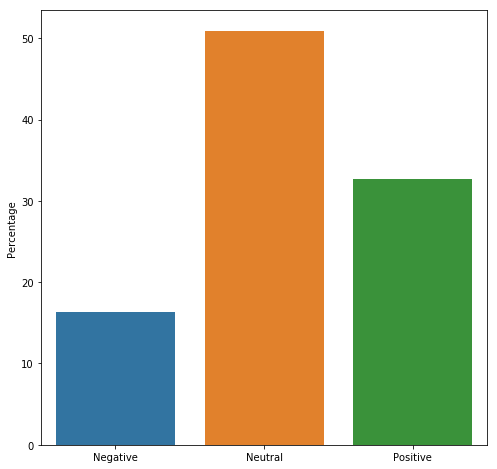

In [28]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 8))

counts = df123.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Count')

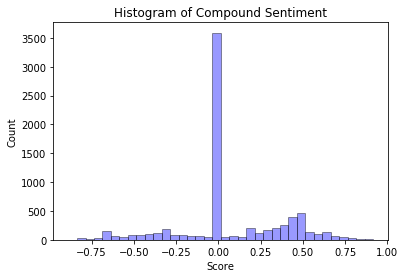

In [29]:

# seaborn histogram
sns.distplot(df123['compound'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Compound Sentiment')
plt.xlabel('Score')
plt.ylabel('Count')

In [30]:
#https://github.com/llSourcell/Stock_Market_Prediction/blob/master/Generating%20Different%20Models.ipynb
#import numpy as np
#import pandas as pd
#from nltk.classify import NaiveBayesClassifier
#from nltk.corpus import subjectivity
#from nltk.sentiment import SentimentAnalyzer
#from nltk.sentiment.util import *
#import nltk
#nltk.downloader.download('vader_lexicon')

#sentence = 'paris shootout police officer suspected guman dead'
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
#import unicodedata
#sid = SentimentIntensityAnalyzer()
#ss = sid.polarity_scores(sentence)
#ss

In [31]:
df123.index =data['publication_date']
df123.head()

,compound,headline,neg,neu,pos,label
publication_date,,,,,,
2015-11-23 22:32:12,-0.3818,Politicians slam tax-avoiding Pfizer-Allergan ...,0.394,0.606,0.0,-1
2015-11-23 23:14:14,0.0000,U.S. Republican Trump calls Pfizer deal to mov...,0.000,1.000,0.0,0
2015-11-24 03:15:02,-0.3818,U.S. politicians slam tax-avoiding Pfizer-Alle...,0.342,0.658,0.0,-1
2015-11-24 03:15:02,0.0000,Pfizer to buy Allergan in $160 billion deal,0.000,1.000,0.0,0
2015-11-24 18:00:05,0.0000,"Pfizer, IIT-Delhi collaborate for healthcare i...",0.000,1.000,0.0,0


In [32]:
df123.to_csv('PFE_sent_news.csv')